In [1]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import colorlover as cl
import neuro_morpho_toolbox as nmt
%matplotlib inline

/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox-0.1-py3.7.egg/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.95
Loading CCF brain structure data...
Loading time: 0.01


**seu_ns: SEU-Allen's data**

**all_ns: SEU + Janelia's data**

Input .swc data file, total **1602**.

<blockquote>Example: Plot three views in a single plot with 256 color</blockquote>

```Python
ns = nmt.neuron_set('/home/penglab/FeaCal/allData')
pickle.dump([ns], open("/home/penglab/FeaCal/all_ns.pickle", "wb"))
```

In [2]:
import pickle
pickle_in = open("/home/penglab/FeaCal/all_ns.pickle","rb")
[ns] = pickle.load(pickle_in)
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)

# 2.1) Distribution of soma location
* Set the *thre* value to determine the threshold for showing the region distribution
* mouseDF is a dataframe recording the ['Child ID', 'Child num', 'ABBR', 'FatherRe'] of 1327 brain regions
* Not going to write mouseDF to the pkg, just to show the result

## 2.1.1) Based on 7 regions
* including Isocortex, OLF, HPF, CTXsp, CNU, BS, CB; 


In [4]:

mouseDF = pd.read_excel('/home/penglab/FeaCal/dataSource/mouseDF.xlsx',index=0)
abbrlist = []
for i in mouseDF.loc[:,'idx']:
    if i in nmt.bs.level.index:
        abbr = nmt.bs.level.loc[i,'Abbreviation']
        abbrlist.append(abbr)
    else:
        print(i)
        abbrlist.append('unknown')
mouseDF.loc[:,'ABBR']=abbrlist
del mouseDF[1]
mouseDF.set_index(['idx'],inplace=True)

somaRegDF = ns.features['soma_features'].region.copy()
large_list = [ 'BS', 'CB','CNU', 'CTXsp', 'HPF','Isocortex', 'OLF']
mouseDF['FatherRe'] = mouseDF.loc[:,'ABBR']
        
for B_iter in large_list :
    temp=[]
    if nmt.bs.name_to_id(B_iter) in mouseDF.index:
        for child_iter in mouseDF.loc[nmt.bs.name_to_id(B_iter),'Child ID'].split():
            if int(child_iter) in mouseDF.index:
                mouseDF.loc[int(child_iter),'FatherRe'] = B_iter
            else:
                print(child_iter)
            #temp.append(nmt.bs.level.loc[int(child_iter),'Abbrevation'])
somaRegDF['main7Region'] = somaRegDF['Region']     
for iterR in somaRegDF.index:
    if somaRegDF.loc[iterR,'Region'] in mouseDF['ABBR'].tolist():
        somaRegDF.loc[iterR,'main7Region'] = mouseDF[mouseDF['ABBR']==somaRegDF.loc[iterR,'Region']].iloc[0,-1]

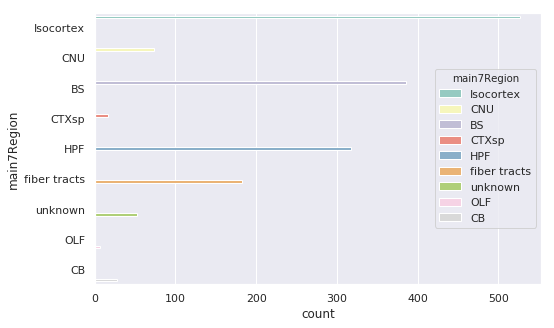

In [5]:
ct = somaRegDF["main7Region"].value_counts().sort_values(ascending=False)
thre = 0
sns.set(rc={'figure.figsize':(8,5)})
_ = sns.countplot(y="main7Region", 
                  data=somaRegDF.loc[somaRegDF.main7Region.isin(ct.index[ct>thre])],
                  hue = "main7Region", palette="Set3"
                 )


## 2.1.2) Projecting to three directions: "Horizontal","Coronal","Sagittal"

**2.1.2.1) By setting color="majorSOMA" in cell_in_map, the soma point will be shown with 7 major regions**
* Here set the 'Cluster' column in ns.metadata to be the region name.

**2.1.2.2) By setting color="soma" in cell_in_map, the soma point will be shown with 256 colors**
* No need to set the 'Cluster' column in ns.metadata to be the region name.

<blockquote>Example: Plot three views in a single plot with 256 color</blockquote>

```Python
    from neuro_morpho_toolbox.plot import cell_in_map
    fig, ax = plt.subplots(3,1, figsize=(7.5, 10))
    cur_list = ns.metadata.index.tolist()
    cell_in_map(ns.neurons, cur_list, ns.metadata, ccf_annotation=nmt.annotation, 
                view="Horizontal", color="soma",alpha=1,ax=ax[0])
    cell_in_map(ns.neurons, cur_list, ns.metadata,ccf_annotation=nmt.annotation, 
                view="Coronal", color="soma", alpha=1,ax=ax[1])
    cell_in_map(ns.neurons,cur_list, ns.metadata, ccf_annotation=nmt.annotation, 
                view="Sagittal", color="soma", alpha=1, ax=ax[2])
    #fig.savefig('../Figure/Cell_in_map.pdf')
```

**2.1.2.1)  Plot singel view('Horizontal') with only 7 major regions**

Illustrating soma locations inside a brain from horizontal view:


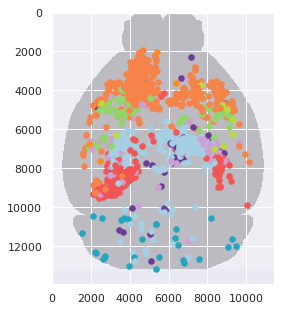

In [6]:
from neuro_morpho_toolbox.plot import cell_in_map
fig, ax =  plt.subplots(1,1)
cur_list = ns.metadata.index.tolist()
somaRegDF['Cluster']= somaRegDF.loc[:,'main7Region']
somaRegDF
cell_in_map(ns.neurons, cur_list, somaRegDF,ccf_annotation=nmt.annotation,view="Horizontal",color="majorsoma",ax=ax
           )
#fig.savefig('/home/penglab/FeaCal/horizonsaved')

**2.1.2.2) Plot singel view('Horizontal') with all regions**

Illustrating soma locations inside a brain from horizontal view:


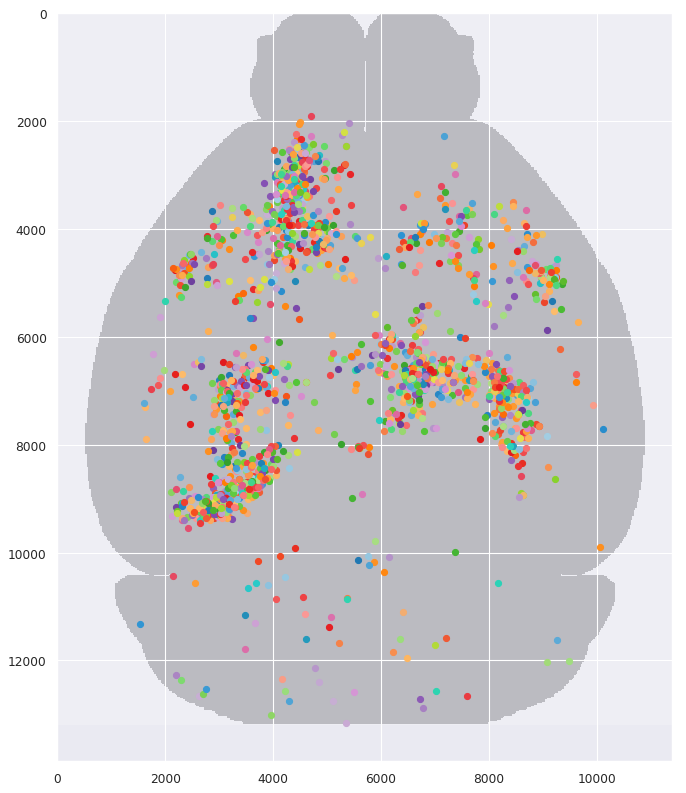

In [7]:
from neuro_morpho_toolbox.plot import cell_in_map
cur_list = ns.metadata.index.tolist()
somaRegDF
cell_in_map(ns.neurons, cur_list, ns.metadata,ccf_annotation=nmt.annotation,view="Horizontal", color="soma")
#fig.savefig('/home/penglab/FeaCal/horizonsaved')

## 2.1.3) Use wordcloud to illustrate the information
* Not going to write into the pkg just to show the result

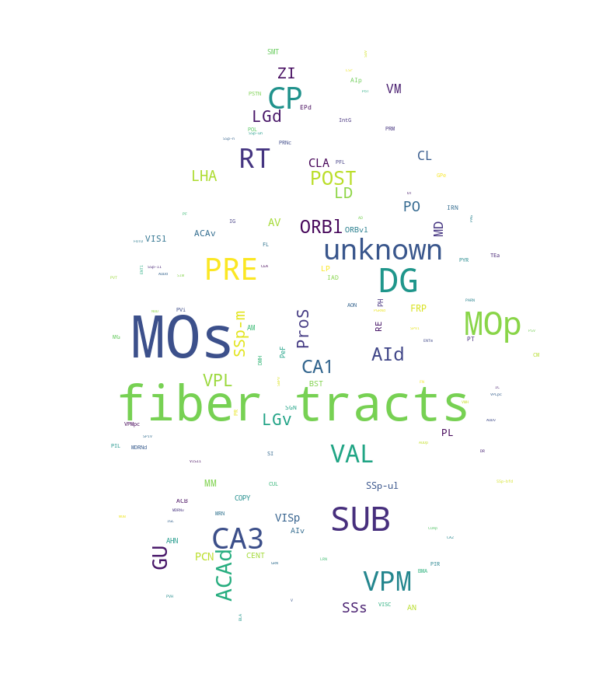

In [8]:
import jieba               
from wordcloud import WordCloud   
from PIL import Image
img = np.array(Image.open("/home/penglab/Desktop/mask.png"))
region_all, count = np.unique(somaRegDF['Region'], return_counts=True)
somaDIC = {}
for i in range(len(region_all)):
    #if region_all[i] == 'fiber tracts':
        #continue
    somaDIC[region_all[i]] = count[i]

wc = WordCloud(background_color='white',width=240,height=160,max_font_size=75,min_font_size=5,
               colormap="viridis", mask = img)
wc.generate_from_frequencies(somaDIC)
#save the file
wc.to_file('/home/penglab/Desktop/WC.png') 
# Show the plot
plt.figure(figsize=(10,20)) 
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()


## 1.1) Analyze soma location to obtain confident list

**Read the downsample-25 array with selected CCF region**

In [9]:
pickle_in = open("/home/penglab/NMTcode/ccf_25.pickle","rb")
example_ = pickle.load(pickle_in)
ccfArray= example_[0]

**Read the 6-nearest neighbor 0-1 Contour Matrix**

In [10]:
pickle_in = open("/home/penglab/NMTcode/CCF_6_01.pickle","rb")
example_ = pickle.load(pickle_in)
CCF_6_01= example_[0]==1

**Read the 6-nearest neighbor Contour Matrix with CCF index on**

* Originally, selected CCF has *316* regions, after using all the selected index to replace the child region, there are *337* regions.
* Therefore, there are 23 regions that show up in the nrrd array but have not been mentioned in the above selected CCF or its child region

In [11]:
pickle_in = open("/home/penglab/NMTcode/CCF_6_M.pickle","rb")
example_ = pickle.load(pickle_in)
CCF_6_M = example_[0]

### function disCal(SOMA_raw,Contour_Matrix, flipF = True, near_n)

calculate the distance among region contour, record the nearest near_n
* **SOMA_raw** input dataframe of soma feature: 
* **Contour_Matrix** =1 for contour points, = 0 for others
* **near_n** number of closest contour points to record
* **flipF** flag to indicate whether flip the soma location or not. Defalt is True

Return
* DataFrame with columns ['x', 'y', 'z', 'SqEuclidean', 'min_Euclidean']
    * The column SqEuclidean will be 'unknown' for region with index 0
    * The column min_Euclidean will be 0. for region with index 0
    * The column mean_Euclidean will be 0. for region with index 0
    * For other regions, the element of SqEuclidean will be a str(list)
    * For other regions, the element of min/mean_Euclidean will be float


In [12]:
from scipy.spatial import distance
import ast
import time
def disCal(SOMA_raw,Contour_01,Array_ID, near_n, flipF = True):
    assert near_n>0, "The number of nearest contour points should be bigger than 0"
    start = time.time()
    scaledDF = pd.DataFrame()
    scaledDF["x"] = (SOMA_raw["x"] / nmt.annotation.space["x"]).copy()
    scaledDF["y"] = (SOMA_raw["y"] / nmt.annotation.space["y"]).copy()
    scaledDF["z"] = (SOMA_raw["z"] / nmt.annotation.space["z"]).copy()
    #flip the somalocation
    if flipF:
        scaledDF["z"][scaledDF['z']>(nmt.annotation.size["z"]//2)] = scaledDF["z"][scaledDF["z"]>(nmt.annotation.size['z']//2)] -nmt.annotation.size["z"]//2 
    i_p = 0
    for idx in scaledDF.index.tolist():
        i_p = i_p+1
        tempCoor = np.array([[scaledDF.loc[idx,'x'],scaledDF.loc[idx,'y'],scaledDF.loc[idx,'z']]])
        tempID = Array_ID[int(scaledDF.loc[idx,'x']),int(scaledDF.loc[idx,'y']),int(scaledDF.loc[idx,'z'])]
        coords = []
        if tempID == 0:
            scaledDF.loc[idx,'SqEuclidean'] = 'unknown'
            scaledDF.loc[idx,'min_Euclidean'] = 0.
            scaledDF.loc[idx,'mean_Euclidean'] = 0.
            continue
        Mask_temp = np.multiply(Array_ID == tempID,Contour_01)#Contour for this tempID
        co_1_temp,co_2_temp,co_3_temp = np.where( Mask_temp >0)
        for icoor in range(len(co_1_temp)):
            coords.append([co_1_temp[icoor], co_2_temp[icoor], co_3_temp[icoor]])
        zs = np.sort(distance.cdist(tempCoor,coords, 'sqeuclidean'))[0,0:min(near_n,distance.cdist(tempCoor,coords, 'sqeuclidean').shape[1])]
        scaledDF.loc[idx,'SqEuclidean'] = str(zs.tolist())
        scaledDF.loc[idx,'min_Euclidean'] = np.sqrt(float(scaledDF.loc[idx,'SqEuclidean'].strip('[]').split(",")[0]))
        scaledDF.loc[idx,'mean_Euclidean'] = np.mean(zs)
        if i_p%10 ==0:
            print('Load progress: %.5f'% (i_p/scaledDF.shape[0]))
    end = time.time()
    print("Total loading time: %.2f" % (end-start))
    scaledDF = scaledDF.fillna(str([0]))
    #scaledDF['min_Euclidean'] = scaledDF.min_Euclidean.astype(float)
    return scaledDF.copy()


<blockquote>Example
</blockquote>

```Python
    somaDis = nmt.disCal(ns.features['soma_features'].raw_data,
                         CCF_6_01,ccfArray, 10, flipF = True)
```


In [13]:
pickle_in = open("/home/penglab/NMTcode/somaDis.pickle","rb")
example_ = pickle.load(pickle_in)
somaDis = example_[0]

In [14]:
selectedDF = somaDis[somaDis['SqEuclidean'] != 'unknown'].copy()
selectedDF = selectedDF[selectedDF['Region'] != 'fiber tracts'].copy()
confi_list = selectedDF.index.tolist()
print('Number of confident neurons are '+ str(len(confi_list)))
se_list = selectedDF.index.tolist()

Number of confident neurons are 1006


## Calculate ARI according to a given list

### Generate the dataframe using pickCLUSTERpara(method)

<blockquote>Example</blockquote>

```Python
    hier_resultDF = pickCLUSTERpara('hierarchy',se_list)
    kmeans_resultDF = pickCLUSTERpara('kmeans',se_list)
    dbscan_resultDF = pickCLUSTERpara('dbscan',se_list)
    hdbscan_resultDF = pickCLUSTERpara('hdbscan',se_list)
    snn_resultDF = pickCLUSTERpara('snn',se_list)
```

In [30]:
snn_resultDF.shape

(270, 3)

In [15]:
import pandas as pd
hier_resultDF = pd.read_excel('/home/penglab/NMTcode/AP/hier_resultDF.xlsx', index_col=0)
kmeans_resultDF = pd.read_excel('/home/penglab/NMTcode/AP/kmeans_resultDF.xlsx', index_col=0)
dbscan_resultDF = pd.read_excel('/home/penglab/NMTcode/AP/dbscan_resultDF.xlsx', index_col=0)
hdbscan_resultDF = pd.read_excel('/home/penglab/NMTcode/AP/hdbscan_resultDF.xlsx', index_col=0)
snn_resultDF = pd.read_excel('/home/penglab/NMTcode/AP/snn_resultDF.xlsx', index_col=0)

### Print out the most proper parameter by maximizing ARI

<blockquote>Example</blockquote>

```Python
    hierbest = findBESTpara(hier_resultDF,[15,45],16)
    kmeansbest = findBESTpara(kmeans_resultDF,[15,45],16)
    dbscanbest = findBESTpara(dbscan_resultDF,[15,45],16)
    hdbscanbest = findBESTpara(hdbscan_resultDF,[15,45],16)
    snnbest = findBESTpara(snn_resultDF,[15,45],16)
```

In [17]:
hierbest = findBESTpara(hier_resultDF,[15,45],16)
kmeansbest = findBESTpara(kmeans_resultDF,[15,45],16)
dbscanbest = findBESTpara(dbscan_resultDF,[15,45],16)
hdbscanbest = findBESTpara(hdbscan_resultDF,[15,45],16)
snnbest = findBESTpara(snn_resultDF,[15,45],16)

Available parameters are: 
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 43, 'optimal_ordering': False, 'colR': 3}
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 39, 'optimal_ordering': False, 'colR': 3}
{'L_method': 'complete', 'L_metric': 'cityblock', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 38, 'optimal_ordering': False, 'colR': 3}
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 36, 'optimal_ordering': False, 'colR': 3}
{'L_method': 'weighted', 'L_metric': 'minkowski', 'criterionH': 'maxclust', 'depth': 15, 'R': None, 't': 37, 'optimal_ordering': False, 'colR': 3}
{'L_method': 'weighted', 'L_metric': 'euclidean', 'criterionH': 'maxclust', 'depth': 15, 'R

Available parameters are: 
{'knn': 5, 'metric': 'l1', 'method': 'FastGreedy'}
{'knn': 5, 'metric': 'manhattan', 'method': 'FastGreedy'}
{'knn': 5, 'metric': 'cityblock', 'method': 'FastGreedy'}
{'knn': 6, 'metric': 'canberra', 'method': 'FastGreedy'}
{'knn': 6, 'metric': 'l1', 'method': 'FastGreedy'}
{'knn': 6, 'metric': 'manhattan', 'method': 'FastGreedy'}
{'knn': 6, 'metric': 'cityblock', 'method': 'FastGreedy'}
{'knn': 7, 'metric': 'canberra', 'method': 'FastGreedy'}
{'knn': 9, 'metric': 'canberra', 'method': 'FastGreedy'}
{'knn': 6, 'metric': 'euclidean', 'method': 'FastGreedy'}
{'knn': 6, 'metric': 'minkowski', 'method': 'FastGreedy'}
{'knn': 6, 'metric': 'l2', 'method': 'FastGreedy'}
{'knn': 5, 'metric': 'chebyshev', 'method': 'FastGreedy'}
{'knn': 5, 'metric': 'minkowski', 'method': 'FastGreedy'}
{'knn': 5, 'metric': 'euclidean', 'method': 'FastGreedy'}
{'knn': 5, 'metric': 'l2', 'method': 'FastGreedy'}
{'knn': 7, 'metric': 'braycurtis', 'method': 'FastGreedy'}


## Using co-clustering towards the selected parameters

### function freq_Matrix(fre_M, cluster_method,para_test)
* **fre_M** is the square DataFrame recording the number of co-clustering
* **cluster_method** can be 'Hierarchy','Kmeans', 'DBSCAN','HDBSCAN','SNN_community'
* **para_test** is the input parameter dictionary for the cluster method
* **iternum** is the number of iteration to generate the coclustering matrix
    
* *Return an array*

In [ ]:
def fre_Matrix(fre_M, cluster_method,para_DF):
    clusterL = self.metadata.index[random.sample(range(0,self.metadata.shape[0]), int(self.metadata.shape[0]*0.95))]
    para_chosen = eval(para_DF.loc[para_DF.index.tolist()[randrange(para_DF.shape[0])],'parameter'])
    _ = self.get_clusters(method =cluster_method,karg_dict = para_chosen,neuron_list =clusterL)
    Crange, Ccounts = np.unique(self.metadata.loc[clusterL,'Cluster'], return_counts = True)
    for iter_C in Crange:
        selected_row = self.metadata.loc[clusterL,:]
        selected_row = selected_row[selected_row["Cluster"]==iter_C]
        Clist = selected_row.index.tolist()
        fre_M.loc[Clist,Clist] = fre_M.loc[Clist,Clist] + 1
    return fre_M.values

In [18]:
import random
from random import randrange
import numpy as np
import multiprocessing
import time


def para_cocluster(cluster_method,para_DF,corenum, run_num):
    start = time.perf_counter ()
    start=time.time()
    cores = corenum#multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=cores)
    fre_M_t = pd.DataFrame(index = ns.UMAP.index, columns =ns.UMAP.index)
    fre_M_t [fre_M_t.isnull()]=0
    pool_list=[]
    result_list=[]
    for i in range(run_num):
        pool_list.append(pool.apply_async(fre_Matrix, (fre_M_t, cluster_method, para_DF)))

    result_list=[xx.get() for xx in pool_list]
    print(sum([xx for xx in  result_list]))
    pool.close()
    pool.join()
    elapsed = (time.time() - start)
    print('Time needed to run Hierarchy is '+ str(elapsed))
    return sum([xx for xx in  result_list])


## Feature 1: projection patterns

AP_hier = para_cocluster('Hierarchy',hierbest,30, 5000)

AP_hierDF = pd.DataFrame(data=AP_hier, index=ns.UMAP.index, columns=ns.UMAP.index)
AP_hierDF.to_excel('/home/penglab/NMTcode/AP_hier_co_cluster.xlsx')


AP_kmeans = para_cocluster('Kmeans',kmeansbest,30, 5000)

AP_kmeansDF = pd.DataFrame(data=AP_kmeans, index=ns.UMAP.index, columns=ns.UMAP.index)
AP_kmeansDF.to_excel('/home/penglab/NMTcode/AP_kmeans_co_cluster.xlsx')


AP_dbscan = para_cocluster('DBSCAN',dbscanbest,30, 5000)

AP_dbscanDF = pd.DataFrame(data=AP_dbscan, index=ns.UMAP.index, columns=ns.UMAP.index)
AP_dbscanDF.to_excel('/home/penglab/NMTcode/AP_dbscan_co_cluster.xlsx')


AP_hdbscan = para_cocluster('HDBSCAN',hdbscanbest,30, 5000)

AP_hdbscanDF = pd.DataFrame(data=AP_hdbscan, index=ns.UMAP.index, columns=ns.UMAP.index)
AP_hdbscanDF.to_excel('/home/penglab/NMTcode/AP_hdbscan_co_cluster.xlsx')


In [19]:
AP_snn = para_cocluster('SNN_community',snnbest,30, 5000)

AP_snnDF = pd.DataFrame(data=AP_snn, index=ns.UMAP.index, columns=ns.UMAP.index)
AP_snnDF.to_excel('/home/penglab/NMTcode/AP_snn_co_cluster.xlsx')


Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_community Clustering
Result of SNN_commun

In [20]:
stopppppppppppppppp

NameError: name 'stopppppppppppppppp' is not defined

In [ ]:

from scipy.spatial import distance
from scipy.cluster import hierarchy
import numpy as np

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster,inconsistent
#print the cocluster result
#output the linkage matrix
def bestCOCLUSTER(df):
    linkmethod = ['single', 'complete','average','weighted','centroid','median','ward']
    paraDF = pd.DataFrame(columns =['method','CCC'],index = linkmethod)
    paraDF.loc[:,'method'] = linkmethod
    
    for iter_m in linkmethod:
        Y = distance.pdist(np.asarray(df))
        Z = hierarchy.linkage(Y, method = iter_m)
        c, coph_dists = hierarchy.cophenet(Z,Y)
        paraDF.loc[iter_m,'CCC'] = c
    paraDF.sort_values(by='CCC', ascending = False, inplace = True)
    #print(paraDF)
    row_linkage = hierarchy.linkage(distance.pdist(np.asarray(df)), method = paraDF.iloc[0,0])

    col_linkage = hierarchy.linkage(distance.pdist(np.asarray(df).T), method = paraDF.iloc[0,0])
    #print(paraDF.iloc[0,0])
    sns.clustermap(df, row_linkage = row_linkage, col_linkage = col_linkage, row_colors=row_colors ,col_colors = row_colors, figsize=(13, 13))#, cmap=sns.diverging_palette(h_neg=150, h_pos=275, s=80, l=55, as_cmap=True))    
    return hierarchy.linkage(distance.pdist(np.asarray(df)))



def coclusterResult(Z_sample):
    t = input('Please input the number of cluster: ')
    return fcluster(Z_sample,t,criterion='maxclust')

In [ ]:
import seaborn as sns; sns.set()




colorlist=["#7FC97F","#BEAED4","#FDC086","#FFFF99","#386CB0","#F0027F","#BF5B17","#666666","#1B9E77","#D95F02",
           "#7570B3","#E7298A","#66A61E","#E6AB02","#A6761D","#666666","#A6CEE3","#1F78B4","#B2DF8A","#33A02C",
           "#FB9A99","#E31A1C","#FDBF6F","#FF7F00","#CAB2D6","#6A3D9A","#FFFF99","#B15928","#FBB4AE","#B3CDE3",
           "#CCEBC5","#DECBE4","#FED9A6","#FFFFCC","#E5D8BD","#FDDAEC","#F2F2F2","#B3E2CD","#FDCDAC","#CBD5E8",
           "#F4CAE4","#E6F5C9","#FFF2AE","#F1E2CC","#CCCCCC","#E41A1C","#377EB8","#4DAF4A","#984EA3","#FF7F00",
           "#FFFF33","#A65628","#F781BF","#999999","#66C2A5","#FC8D62","#8DA0CB","#E78AC3","#A6D854","#FFD92F",
           "#E5C494","#B3B3B3","#8DD3C7","#FFFFB3","#BEBADA","#FB8072","#80B1D3","#FDB462","#B3DE69","#FCCDE5",
           "#D9D9D9","#BC80BD","#CCEBC5"]
lut = dict(zip(ns.metadata['CellType'].unique(), colorlist))
row_colors = ns.metadata['CellType'].map(lut)
row_colors[row_colors.isnull()]='white'

In [ ]:
Ztemp= bestCOCLUSTER(DM_hierDF)


In [ ]:
import pickle
def generateNS(featureDF,ns_input,Z_sample,storePath,outname):
    if featureDF.shape!= (0,0):
        pickle_in = open("/home/penglab/FeaCal/ns.pickle","rb")
        example_ = pickle.load(pickle_in)
        ns_input= example_[0]

        index_origin = ns_input.metadata.index.tolist()
        ns_input.UMAP = nmt.UMAP_wrapper(featureDF, n_neighbors=100, min_dist=0.1, n_components=2, 
                                         metric='euclidean',PCA_first=True,n_PC=100)
        index_after = ns_input.UMAP.index.tolist()
        if len(index_after)>len(index_origin ):
            index_update = [i for i in index_after if i in index_origin ]
        else:
            index_update = [i for i in index_origin if i in index_after ]
        
        ns_input.metadata = ns_input.metadata.loc[index_update,:]
    cur_clusters = coclusterResult(Z_sample)
    ns_input.metadata['Cluster'] = ['C' + str(i) for i in cur_clusters] 
    _ = ns_input.FeatureScatter(["CellType", "Hemisphere","Cluster"], map="UMAP")
    return ns_input

In [ ]:
AP_hierDF  = DM_hierDF

In [ ]:
Ztemp= bestCOCLUSTER(AP_hierDF)
generateNS(pd.DataFrame(),ns,Ztemp,'/home/penglab/FeaCal/','AP_hier_ns')

In [ ]:
_ = ns.FeatureScatter(["CellType", "Hemisphere","Cluster"], map="UMAP")

In [ ]:
DM_kmeans = para_cocluster('Kmeans', par_kmeans2,30, 5000,ns)
DM_kmeansDF = pd.DataFrame(data=DM_kmeans, index=ns.UMAP.index, columns=ns.UMAP.index)
DM_kmeansDF.to_excel('/home/penglab/FeaCal/dataSource/denMor/DM_kmeansDF.xlsx')



In [ ]:
# df = pd.read_excel("../Subjective_celltype/tracking_table_QW_hz_LjL_08082019.xlsx", index_col=[0])
# metadata = ns.features['soma_features'].region
# df = df.loc[metadata.index]
# df.to_excel("../Subjective_celltype/tracking_table_QW_hz_LjL_08082019.284_cells.xlsx")

In [ ]:
df = pd.read_excel("../Subjective_celltype/tracking_table.284_cells.xlsx", index_col=[0])
region_list = pd.read_excel("../Subjective_celltype/tracking_table.284_cells.xlsx", sheet_name=1, header=None)[2].tolist()

metadata = ns.features['soma_features'].region.copy()
metadata['Celltype'] = df.loc[metadata.index, "Confirmed"]
# # metadata['Celltype_note'] = df.loc[metadata.index, "Lijuan Note"]
# # metadata.loc[metadata["Celltype_note"]=="CPU", "Celltype"] = "CPU"
metadata.fillna("Others", inplace=True)
metadata.loc[metadata.Celltype.isin(["TH", "VPM/VPL"]), "Celltype"] = "TH_Uncertain"
metadata.loc[~metadata.Celltype.isin(["Others", "TH_Uncertain"]+region_list), "Celltype"] = "Others"
print(metadata.Celltype.value_counts())
# metadata
pickle.dump([metadata], open("metadata.pickle", "wb"))

## Color setting

In [ ]:
bupu = cl.scales['9']['seq']['BuPu']
greens = cl.scales['9']['seq']['Greens']
set2 = cl.scales['7']['qual']['Set2']
spectral = cl.scales['9']['div']['Spectral']
paired = cl.scales['10']['qual']['Paired']
mpl_colors = []
for i in range(9):
    tp = []
    for j in list(matplotlib.colors.to_rgb("C"+str(i))):
        tp.append(str(int(j*255)))
    tp = ", ".join(tp)
    tp = "rgb(" + tp + ")"
    mpl_colors.append(tp)
   
def rgb_to_list(rgb_str):
    tp = rgb_str.replace("rgb(", "").replace("rgba(", "").replace(")", "")
    res = [float(i)/255 for i in tp.split(", ")]
    return res

def get_celltype_colors(metadata):
    u_celltypes = sorted(list(set(metadata.Celltype)))
    color_list = cl.to_rgb(cl.interp(paired, len(u_celltypes)))
    color_list = [rgb_to_list(i) for i in color_list]
    celltype_colors = dict(zip(u_celltypes, color_list))
    if "Others" in u_celltypes:
        celltype_colors["Others"] = rgb_to_list('rgb(128, 128, 128)')
    return celltype_colors

celltype_color_dict = get_celltype_colors(metadata)

pickle.dump([celltype_color_dict], open("colors.pickle", "wb"))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,8))
for i, key in enumerate(list(celltype_color_dict.keys())):
    ax.scatter(0.001, len(celltype_color_dict) - i, c=celltype_color_dict[key], s=100)
    ax.text(0.002, len(celltype_color_dict) - i, key, 
            horizontalalignment='left',
            verticalalignment="center",
            fontdict={"size":16}
           )
    ax.set_xlim(0, 0.01)
    ax.axis("off")

In [ ]:
ns.metadata["CellType"] = metadata.loc[ns.metadata.index, "Celltype"]
clusters = pd.read_csv("clusters.csv", index_col=[0])
ns.metadata['Cluster'] = clusters.loc[ns.metadata.index, "Cluster"]
ns.metadata["CellType_note"] = metadata.loc[ns.metadata.index, "Celltype_note"]

In [ ]:
pickle.dump([ns], open("neuron_set.pickle", "wb"))

In [ ]:
ns.features['projection_features'].normalize(log=True)
pickle.dump([ns.features['projection_features']], open("features_projection.pickle", "wb"))

In [ ]:
ns.features['projection_features'].scaled_data

## Feature 2: soma locations

In [ ]:
pickle.dump([ns.features['soma_features']], open("features_soma.pickle", "wb"))

## Feature 3: axon morphological features

In [ ]:
# 1. Axon overall
df1 = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df1.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df1 = df1[use_cols]

feature_name = use_cols
new_feature_name = ['A_'+i.replace(' ', '_') for i in use_cols]
df1.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)


In [ ]:
# 2. Local axon
df2 = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df2.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df2 = df2[use_cols]

feature_name = use_cols
new_feature_name = ['AL_'+i.replace(' ', '_') for i in use_cols]
df2.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)

In [ ]:
df = pd.concat([df1, df2], axis=1)
lm_axon = nmt.features("L-measure of axon")
lm_axon.add_raw_data(df)

pickle.dump([lm_axon], open("features_lm_axon.pickle", "wb"))

## Feature 4: dendrite morphological features

In [ ]:
df = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df = df[use_cols]

feature_name = use_cols
new_feature_name = ['D_'+i.replace(' ', '_') for i in use_cols]
df.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)

lm_dendrite = nmt.features("L-measure of dendrite")
lm_dendrite.add_raw_data(df)

pickle.dump([lm_dendrite], open("features_lm_dendrite.pickle", "wb"))

In [ ]:
print(np.log(10000), np.log(5000))